# StackedAutoEncoder predictor

## Author: Danilo Filippo Reiszel Pereira
Univesidade Federal do Rio de Janeiro

This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of PETR4 stocks, as input 10 delays of it's return series, using the StackedAutoEncoder approach for pre-training

In [1]:
from __future__ import print_function
import sys, os
sys.path.append('../../../../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


## Global Params
Setting global params and useful variables, such as directories and image styling

In [2]:
pathPETR4 = '../../../../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../../../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../../../../data/forex/USDBRL/diario/USDBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
os.makedirs(saveVarDir) if not os.path.exists(saveVarDir) else print('')

saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('')

saveModelDir = './Models'
os.makedirs(saveModelDir) if not os.path.exists(saveModelDir) else print('')

saveImgFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

## Data Acquisition and Preprocessing

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

<strong>Parameters for trend extraction:</strong>
<ul>
    <li>Column: Close</li>
    <li>Decompose model: Additive</li>
    <li>Fitting Order: 1 (by default)</li>
    <li>Window Size: 6</li>
    <li>Fitting Weigths Model: Autocorrelation</li>
    <li>Fitting Weigths Model Window Size: 18</li>
</ul>

In [3]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    deTrendParams = {'column': 'Close', 'window': 6, 'model': decomposeModel, 
                                     'weightModel': 'window_acorr', 'weightModelWindow': 18},
                    colPrefix = 'PETR4',
                    dropNan = True
                   )

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True
                  )

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True
                   )


end_time = time.time()
print('Time to acquire and process data: '+str(end_time-init_time)+' seconds')

Time to acquire and process data: 11.1826369762 seconds


## Dataset concatenation and selection of wich features to feed to the model

In [9]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = ['PETR4_Close_resid',
                'PETR4_Close_rollStd20', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns',
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff',
               ]

## Creation of feature matrix and output array, split of data in Train, Validation and Test sets
All data from 2017 is used as Test set, reamining data is split into train and validation according to *validationSplitSize*

In [10]:
xTrain, yTrain, xVal, yVal, xTest, yTest = prepData(df = df, 
                                                    columnsToUse = columnsToUse, 
                                                    columnToPredict = 'PETR4_Close_resid', 
                                                    nDelays = 10, 
                                                    testSetSize = len(df['2017']), 
                                                    validationSplitSize = 0.15
                                                   )

print('Number of batches in training set: {}'.format(len(xTrain)))
print('Number of batches in validation set: {}'.format(len(xVal)))
print('Number of batches in test set: {}'.format(len(xTest)))
print('Number of features per batch: {}'.format(len(xTrain[1])))

Number of batches in training set: 3557
Number of batches in validation set: 628
Number of batches in test set: 175
Number of features per batch: 40


## Feature Scalling
Technique used: Normalisation

In [12]:
xScaler = MinMaxScaler(feature_range = (-1,1))
xScaler.fit(xTrain)

yScaler = MinMaxScaler(feature_range = (-1,1))
yScaler.fit(yTrain)

xTrain = xScaler.transform(xTrain)
xVal = xScaler.transform(xVal)
xTest  = xScaler.transform(xTest)

yTrain = yScaler.transform(yTrain)
yVal = yScaler.transform(yVal)

## Creation and initializaion of a single hidden layer autoencoder

In [17]:
inputDim = len(xTrain[1])

autoencoder = Sequential([
                          Dense(20, activation = 'tanh', kernel_initializer = 'uniform', input_dim = inputDim),
                          Dense(inputDim, activation = 'tanh', kernel_initializer = 'uniform')
                         ])

#SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)

autoencoder.compile(optimizer = 'adam', loss='mse', metrics=['accuracy', 'mae'])
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 40)                840       
Total params: 1,660
Trainable params: 1,660
Non-trainable params: 0
_________________________________________________________________


## Fitting the model to data

In [26]:
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

init_time = time.time()

fitHistory = autoencoder.fit(xTrain, 
                             xTrain, 
                             epochs = 2000,
                             verbose = 1,
                             shuffle = True,
                             validation_data = (xVal, xVal), 
                             callbacks = [earlyStopping])

end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Train on 3557 samples, validate on 628 samples
Epoch 1/2000
3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7265 - mean_absolute_error: 0.0376 - val_loss: 0.0032 - val_acc: 0.7293 - val_mean_absolute_error: 0.0377
Epoch 2/2000
3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7290 - mean_absolute_error: 0.0375 - val_loss: 0.0032 - val_acc: 0.7309 - val_mean_absolute_error: 0.0379
Epoch 3/2000
3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7287 - mean_absolute_error: 0.0376 - val_loss: 0.0032 - val_acc: 0.7166 - val_mean_absolute_error: 0.0381
Epoch 4/2000
3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7256 - mean_absolute_error: 0.0376 - val_loss: 0.0032 - val_acc: 0.7197 - val_mean_absolute_error: 0.0379
Epoch 5/2000
3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7281 - mean_absolute_error: 0.0376 - val_loss: 0.0032 - val_acc: 0.7166 - val_mean_absolute_error: 0.037

3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7284 - mean_absolute_error: 0.0373 - val_loss: 0.0032 - val_acc: 0.7309 - val_mean_absolute_error: 0.0375
Epoch 44/2000
3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7304 - mean_absolute_error: 0.0373 - val_loss: 0.0032 - val_acc: 0.7373 - val_mean_absolute_error: 0.0376
Epoch 45/2000
3557/3557 [==============================] - 0s - loss: 0.0030 - acc: 0.7262 - mean_absolute_error: 0.0373 - val_loss: 0.0032 - val_acc: 0.7293 - val_mean_absolute_error: 0.0377
Time to fit model: 3.66910004616 seconds


## Visualizing the Training History

In [ ]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_autoencoder_30_40', 'pdf'), bbox_inches='tight')

## Extracting autoencoder first layer to be used as encoder

In [28]:
encoder1layer = autoencoder.get_layer(index=1)
encoder1 = Sequential([encoder1layer])
encoder1.compile(optimizer = 'adam', loss='mse')
encoder1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                820       
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________


## Encoding data for use as input in the next autoencoder 

In [29]:
xTrainEncoded1 = encoder1.predict(xTrain)
xValEncoded1 = encoder1.predict(xVal)

## Creating another autoencoder, for second layer 

In [30]:
inputDim = len(xTrainEncoded1[1])

autoencoder2 = Sequential([
                           Dense(20, activation = 'tanh', kernel_initializer = 'uniform', input_dim = inputDim),
                           Dense(inputDim, activation = 'tanh', kernel_initializer = 'uniform')
                          ])

#SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)

autoencoder2.compile(optimizer = 'adam', loss='mse', metrics=['accuracy', 'mae'])
autoencoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
Total params: 840
Trainable params: 840
Non-trainable params: 0
_________________________________________________________________


In [32]:
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

init_time = time.time()

fitHistory = autoencoder2.fit(xTrainEncoded1, 
                              xTrainEncoded1, 
                              epochs = 2000,
                              verbose = 1,
                              shuffle = True,
                              validation_data = (xValEncoded1, xValEncoded1), 
                              callbacks = [earlyStopping])

end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Train on 3557 samples, validate on 628 samples
Epoch 1/2000
3557/3557 [==============================] - 0s - loss: 0.0406 - acc: 0.3337 - mean_absolute_error: 0.1572 - val_loss: 0.0286 - val_acc: 0.4777 - val_mean_absolute_error: 0.1297
Epoch 2/2000
3557/3557 [==============================] - 0s - loss: 0.0225 - acc: 0.5277 - mean_absolute_error: 0.1137 - val_loss: 0.0163 - val_acc: 0.6481 - val_mean_absolute_error: 0.0959
Epoch 3/2000
3557/3557 [==============================] - 0s - loss: 0.0134 - acc: 0.6073 - mean_absolute_error: 0.0872 - val_loss: 0.0108 - val_acc: 0.7070 - val_mean_absolute_error: 0.0769
Epoch 4/2000
3557/3557 [==============================] - 0s - loss: 0.0093 - acc: 0.6646 - mean_absolute_error: 0.0715 - val_loss: 0.0079 - val_acc: 0.7548 - val_mean_absolute_error: 0.0644
Epoch 5/2000
3557/3557 [==============================] - 0s - loss: 0.0070 - acc: 0.7093 - mean_absolute_error: 0.0608 - val_loss: 0.0061 - val_acc: 0.7755 - val_mean_absolute_error: 0.055

3557/3557 [==============================] - 0s - loss: 1.3434e-04 - acc: 0.9559 - mean_absolute_error: 0.0072 - val_loss: 1.5205e-04 - val_acc: 0.9522 - val_mean_absolute_error: 0.0072
Epoch 43/2000
3557/3557 [==============================] - 0s - loss: 1.3231e-04 - acc: 0.9547 - mean_absolute_error: 0.0072 - val_loss: 1.4803e-04 - val_acc: 0.9586 - val_mean_absolute_error: 0.0070
Epoch 44/2000
3557/3557 [==============================] - 0s - loss: 1.3010e-04 - acc: 0.9567 - mean_absolute_error: 0.0071 - val_loss: 1.4903e-04 - val_acc: 0.9522 - val_mean_absolute_error: 0.0073
Epoch 45/2000
3557/3557 [==============================] - 0s - loss: 1.2911e-04 - acc: 0.9581 - mean_absolute_error: 0.0070 - val_loss: 1.4522e-04 - val_acc: 0.9602 - val_mean_absolute_error: 0.0072
Epoch 46/2000
3557/3557 [==============================] - 0s - loss: 1.2714e-04 - acc: 0.9584 - mean_absolute_error: 0.0070 - val_loss: 1.4562e-04 - val_acc: 0.9538 - val_mean_absolute_error: 0.0073
Epoch 47/2000


3557/3557 [==============================] - 0s - loss: 1.0191e-04 - acc: 0.9581 - mean_absolute_error: 0.0062 - val_loss: 1.2088e-04 - val_acc: 0.9506 - val_mean_absolute_error: 0.0065
Epoch 84/2000
3557/3557 [==============================] - 0s - loss: 1.0260e-04 - acc: 0.9578 - mean_absolute_error: 0.0063 - val_loss: 1.1556e-04 - val_acc: 0.9522 - val_mean_absolute_error: 0.0063
Epoch 85/2000
3557/3557 [==============================] - 0s - loss: 1.0146e-04 - acc: 0.9587 - mean_absolute_error: 0.0062 - val_loss: 1.1785e-04 - val_acc: 0.9522 - val_mean_absolute_error: 0.0062
Epoch 86/2000
3557/3557 [==============================] - 0s - loss: 1.0241e-04 - acc: 0.9587 - mean_absolute_error: 0.0062 - val_loss: 1.1640e-04 - val_acc: 0.9570 - val_mean_absolute_error: 0.0064
Epoch 87/2000
3557/3557 [==============================] - 0s - loss: 1.0138e-04 - acc: 0.9561 - mean_absolute_error: 0.0062 - val_loss: 1.1692e-04 - val_acc: 0.9570 - val_mean_absolute_error: 0.0062
Epoch 88/2000


3557/3557 [==============================] - 0s - loss: 9.3185e-05 - acc: 0.9595 - mean_absolute_error: 0.0059 - val_loss: 1.1097e-04 - val_acc: 0.9490 - val_mean_absolute_error: 0.0061
Epoch 124/2000
3557/3557 [==============================] - 0s - loss: 9.3539e-05 - acc: 0.9598 - mean_absolute_error: 0.0060 - val_loss: 1.0981e-04 - val_acc: 0.9554 - val_mean_absolute_error: 0.0063
Epoch 125/2000
3557/3557 [==============================] - 0s - loss: 9.3679e-05 - acc: 0.9620 - mean_absolute_error: 0.0060 - val_loss: 1.0693e-04 - val_acc: 0.9570 - val_mean_absolute_error: 0.0061
Epoch 126/2000
3557/3557 [==============================] - 0s - loss: 9.2669e-05 - acc: 0.9590 - mean_absolute_error: 0.0059 - val_loss: 1.1027e-04 - val_acc: 0.9538 - val_mean_absolute_error: 0.0064
Epoch 127/2000
3557/3557 [==============================] - 0s - loss: 9.3238e-05 - acc: 0.9595 - mean_absolute_error: 0.0059 - val_loss: 1.0889e-04 - val_acc: 0.9490 - val_mean_absolute_error: 0.0062
Epoch 128/

3557/3557 [==============================] - 0s - loss: 8.7996e-05 - acc: 0.9612 - mean_absolute_error: 0.0057 - val_loss: 1.0733e-04 - val_acc: 0.9506 - val_mean_absolute_error: 0.0061
Epoch 164/2000
3557/3557 [==============================] - 0s - loss: 8.8586e-05 - acc: 0.9598 - mean_absolute_error: 0.0058 - val_loss: 1.0332e-04 - val_acc: 0.9554 - val_mean_absolute_error: 0.0060
Epoch 165/2000
3557/3557 [==============================] - 0s - loss: 8.8694e-05 - acc: 0.9570 - mean_absolute_error: 0.0058 - val_loss: 1.0764e-04 - val_acc: 0.9602 - val_mean_absolute_error: 0.0059
Epoch 166/2000
3557/3557 [==============================] - 0s - loss: 8.8419e-05 - acc: 0.9590 - mean_absolute_error: 0.0058 - val_loss: 1.0229e-04 - val_acc: 0.9554 - val_mean_absolute_error: 0.0058
Epoch 167/2000
3557/3557 [==============================] - 0s - loss: 8.8760e-05 - acc: 0.9606 - mean_absolute_error: 0.0058 - val_loss: 1.0245e-04 - val_acc: 0.9475 - val_mean_absolute_error: 0.0059
Epoch 168/

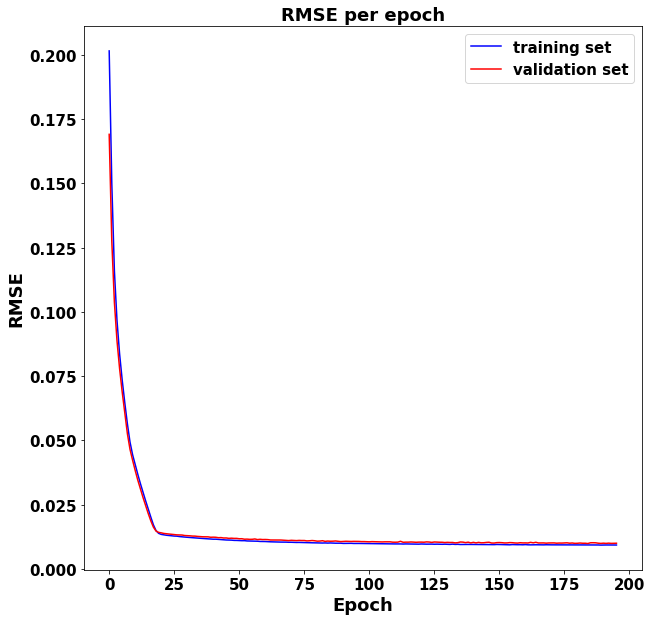

In [33]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_autoencoder_30_40', 'pdf'), bbox_inches='tight')

## Extracting autoencoder2 first layer to be used as encoder2

In [34]:
encoder2layer = autoencoder2.get_layer(index=1)
encoder2 = Sequential([encoder2layer])
encoder2.compile(optimizer = 'adam', loss='mse')
encoder2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                420       
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________


## Encoding data for use as input in the next autoencoder 

In [37]:
xTrainEncoded2 = encoder2.predict(xTrainEncoded1)
xValEncoded2 = encoder2.predict(xValEncoded1)

## Creating another autoencoder, for third layer 

In [40]:
inputDim = len(xTrainEncoded2[1])

autoencoder3 = Sequential([
                           Dense(10, activation = 'tanh', kernel_initializer = 'uniform', input_dim = inputDim),
                           Dense(inputDim, activation = 'tanh', kernel_initializer = 'uniform')
                          ])

#SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)

autoencoder3.compile(optimizer = 'adam', loss='mse', metrics=['accuracy', 'mae'])
autoencoder3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 20)                220       
Total params: 430
Trainable params: 430
Non-trainable params: 0
_________________________________________________________________


In [41]:
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

init_time = time.time()

fitHistory = autoencoder3.fit(xTrainEncoded2, 
                              xTrainEncoded2, 
                              epochs = 2000,
                              verbose = 1,
                              shuffle = True,
                              validation_data = (xValEncoded2, xValEncoded2), 
                              callbacks = [earlyStopping])

end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Train on 3557 samples, validate on 628 samples
Epoch 1/2000
3557/3557 [==============================] - 0s - loss: 0.0169 - acc: 0.2676 - mean_absolute_error: 0.1025 - val_loss: 0.0113 - val_acc: 0.3121 - val_mean_absolute_error: 0.0820
Epoch 2/2000
3557/3557 [==============================] - 0s - loss: 0.0107 - acc: 0.3492 - mean_absolute_error: 0.0793 - val_loss: 0.0094 - val_acc: 0.4124 - val_mean_absolute_error: 0.0742
Epoch 3/2000
3557/3557 [==============================] - 0s - loss: 0.0089 - acc: 0.4397 - mean_absolute_error: 0.0720 - val_loss: 0.0075 - val_acc: 0.5191 - val_mean_absolute_error: 0.0655
Epoch 4/2000
3557/3557 [==============================] - 0s - loss: 0.0069 - acc: 0.5412 - mean_absolute_error: 0.0629 - val_loss: 0.0059 - val_acc: 0.5780 - val_mean_absolute_error: 0.0571
Epoch 5/2000
3557/3557 [==============================] - 0s - loss: 0.0056 - acc: 0.5890 - mean_absolute_error: 0.0554 - val_loss: 0.0049 - val_acc: 0.6131 - val_mean_absolute_error: 0.051

3557/3557 [==============================] - 0s - loss: 0.0035 - acc: 0.6728 - mean_absolute_error: 0.0430 - val_loss: 0.0034 - val_acc: 0.6720 - val_mean_absolute_error: 0.0421
Epoch 44/2000
3557/3557 [==============================] - 0s - loss: 0.0035 - acc: 0.6719 - mean_absolute_error: 0.0430 - val_loss: 0.0034 - val_acc: 0.6752 - val_mean_absolute_error: 0.0422
Epoch 45/2000
3557/3557 [==============================] - 0s - loss: 0.0035 - acc: 0.6736 - mean_absolute_error: 0.0430 - val_loss: 0.0034 - val_acc: 0.6688 - val_mean_absolute_error: 0.0421
Epoch 46/2000
3557/3557 [==============================] - 0s - loss: 0.0035 - acc: 0.6739 - mean_absolute_error: 0.0429 - val_loss: 0.0034 - val_acc: 0.6704 - val_mean_absolute_error: 0.0422
Epoch 47/2000
3557/3557 [==============================] - 0s - loss: 0.0035 - acc: 0.6747 - mean_absolute_error: 0.0429 - val_loss: 0.0034 - val_acc: 0.6736 - val_mean_absolute_error: 0.0422
Epoch 48/2000
3557/3557 [=============================

## Extracting autoencoder3 first layer to be used as encoder3

In [43]:
encoder3layer = autoencoder3.get_layer(index=1)

## Building SAE

In [72]:
_encoder1layer = autoencoder.get_layer(index=1)
_encoder2layer = autoencoder2.get_layer(index=1)
_encoder3layer = autoencoder3.get_layer(index=1)

_encoder1layer.trainable = False
_encoder2layer.trainable = False
_encoder3layer.trainable = False

SAE = Sequential([
                  _encoder1layer, 
                  _encoder2layer, 
                  _encoder3layer,
                  Dense(1, activation='linear', kernel_initializer = 'uniform')
                 ])

SGD = optimizers.SGD(lr=0.03, momentum=0.10, decay=0.0, nesterov=False)

SAE.compile(optimizer = 'adam', loss='mse', metrics=['accuracy', 'mae'])
SAE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 1,461
Trainable params: 11
Non-trainable params: 1,450
_________________________________________________________________


In [73]:
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

init_time = time.time()

fitHistory = SAE.fit(xTrain, 
                     yTrain, 
                     epochs = 2000,
                     verbose = 1,
                     shuffle = True,
                     validation_data = (xVal, yVal), 
                     callbacks = [earlyStopping])

end_time = time.time()

print('Time to fit model: '+str(end_time-init_time)+' seconds')

Train on 3557 samples, validate on 628 samples
Epoch 1/2000
3557/3557 [==============================] - 0s - loss: 0.0185 - acc: 0.0000e+00 - mean_absolute_error: 0.0893 - val_loss: 0.2045 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2969
Epoch 2/2000
3557/3557 [==============================] - 0s - loss: 0.0160 - acc: 0.0000e+00 - mean_absolute_error: 0.0818 - val_loss: 0.1991 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2927
Epoch 3/2000
3557/3557 [==============================] - 0s - loss: 0.0155 - acc: 0.0000e+00 - mean_absolute_error: 0.0804 - val_loss: 0.1966 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2902
Epoch 4/2000
3557/3557 [==============================] - 0s - loss: 0.0154 - acc: 0.0000e+00 - mean_absolute_error: 0.0801 - val_loss: 0.1948 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2878
Epoch 5/2000
3557/3557 [==============================] - 0s - loss: 0.0154 - acc: 0.0000e+00 - mean_absolute_error: 0.0800 - val_loss: 0.1947 - val_acc: 0.0

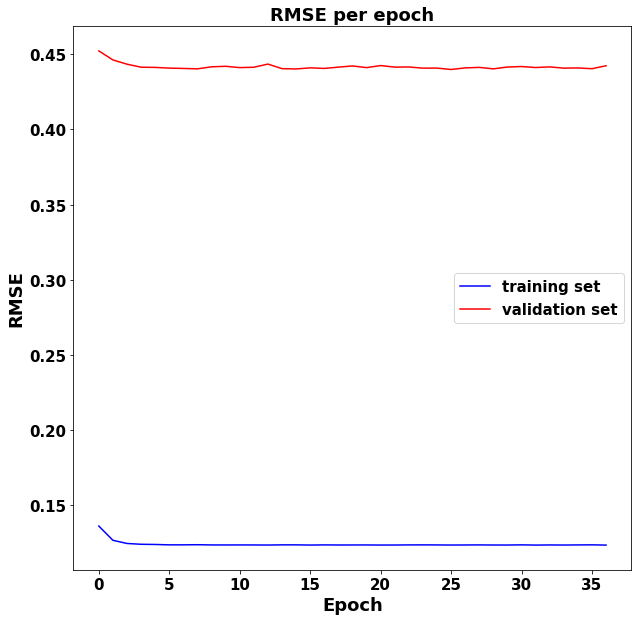

In [74]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_autoencoder_30_40', 'pdf'), bbox_inches='tight')

In [79]:
SAE.layers[3].trainable = False

for i in range(3):
    SAE.layers[i].trainable = True
    
    init_time = time.time()

    fitHistory = SAE.fit(xTrain, 
                         yTrain, 
                         epochs = 2000,
                         verbose = 1,
                         shuffle = True,
                         validation_data = (xVal, yVal), 
                         callbacks = [earlyStopping])

    end_time = time.time()
    print('Time to fit layer ' + str(i) +': '+str(end_time-init_time)+' seconds')

Train on 3557 samples, validate on 628 samples
Epoch 1/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0798 - val_loss: 0.1935 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2867
Epoch 2/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0796 - val_loss: 0.1949 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2892
Epoch 3/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0795 - val_loss: 0.1946 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2891
Epoch 4/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0798 - val_loss: 0.1933 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2865
Epoch 5/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0798 - val_loss: 0.1946 - val_acc: 0.0

3557/3557 [==============================] - 0s - loss: 0.0152 - acc: 0.0000e+00 - mean_absolute_error: 0.0796 - val_loss: 0.1943 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2886
Epoch 11/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0797 - val_loss: 0.1937 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2874
Epoch 12/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0797 - val_loss: 0.1949 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2899
Epoch 13/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0796 - val_loss: 0.1938 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2875
Epoch 14/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0798 - val_loss: 0.1947 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2892
Epoch 15/2000


In [80]:
SAE.layers[0].trainable = True
SAE.layers[1].trainable = True
SAE.layers[2].trainable = True
SAE.layers[3].trainable = True

init_time = time.time()

fitHistory = SAE.fit(xTrain, 
                     yTrain, 
                     epochs = 2000,
                     verbose = 1,
                     shuffle = True,
                     validation_data = (xVal, yVal), 
                     callbacks = [earlyStopping])

end_time = time.time()
print('Time to fit model: '+str(end_time-init_time)+' seconds')

Train on 3557 samples, validate on 628 samples
Epoch 1/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0796 - val_loss: 0.1935 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2870
Epoch 2/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0797 - val_loss: 0.1947 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2893
Epoch 3/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0797 - val_loss: 0.1936 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2872
Epoch 4/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0798 - val_loss: 0.1946 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2888
Epoch 5/2000
3557/3557 [==============================] - 0s - loss: 0.0153 - acc: 0.0000e+00 - mean_absolute_error: 0.0797 - val_loss: 0.1956 - val_acc: 0.0

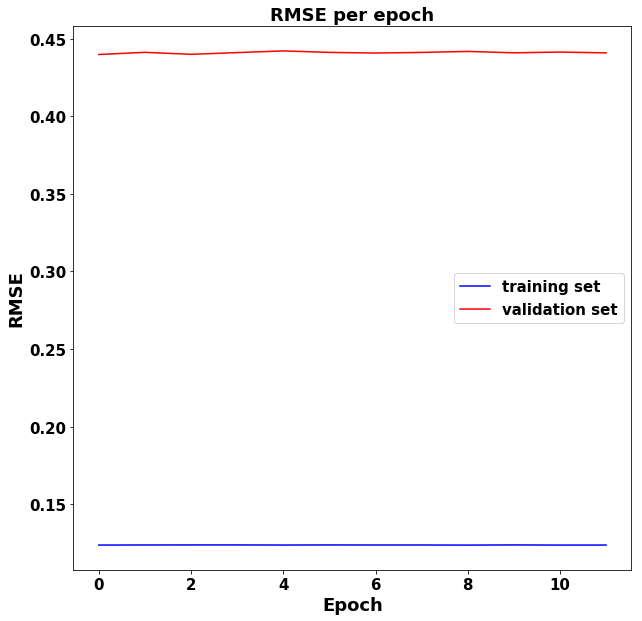

In [81]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(fitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(fitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
#fig.savefig('{}/{}.{}'.format(saveFigDir, 'RMSE_per_epoch_autoencoder_30_40', 'pdf'), bbox_inches='tight')

## Visualizing Predictions

(<matplotlib.figure.Figure at 0x11bef2d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10c75d50>)

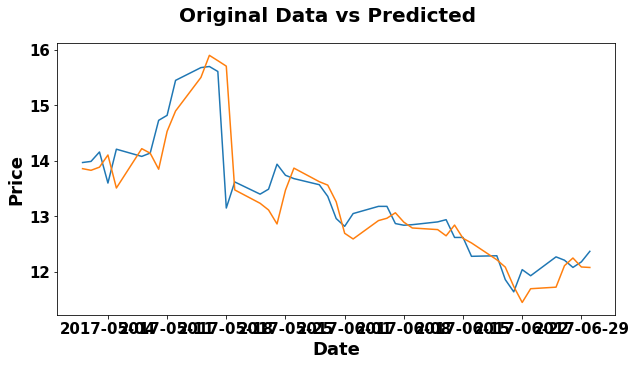

In [82]:
predictions = SAE.predict(xTest)
predictions = yScaler.inverse_transform(predictions)
predictions_clean = []
for p in predictions:
    predictions_clean.extend(p)
predictionsSeries = pd.Series(predictions_clean, index = df['2017'].index)

plotSeries([df['PETR4_Close_trend']+ df['PETR4_Close_resid'], 
#            df['PETR4_Close_trend'],
            df['PETR4_Close_trend'] + predictionsSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

(<matplotlib.figure.Figure at 0x110e0950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10af2650>)

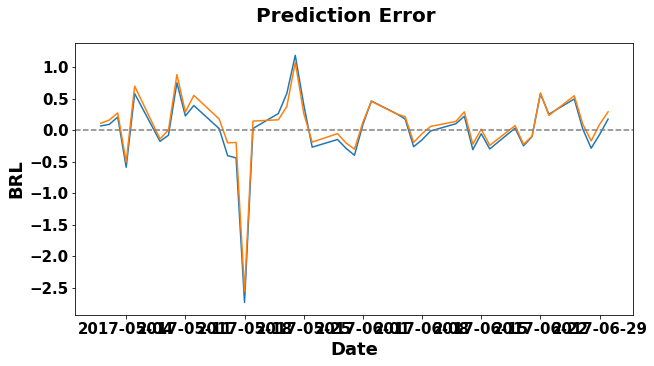

In [83]:
plotSeries([df['PETR4_Close_resid'], (df['PETR4_Close_resid'] - predictionsSeries)],
           plotZeroLine = True,
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')